In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
from google.colab.patches import cv2_imshow
cv2.ocl.setUseOpenCL(False)

In [ ]:
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

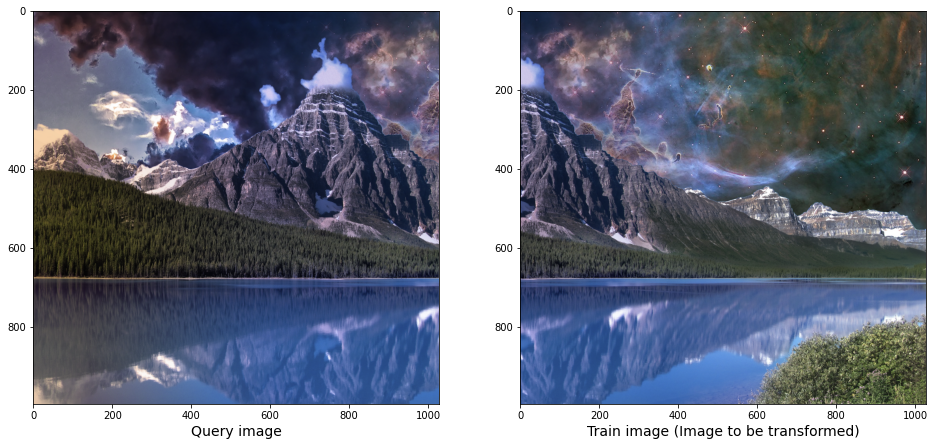

In [ ]:
trainImg = imageio.imread('/1.png')    #training images#
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)

queryImg = imageio.imread('/2.png')

queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [ ]:
def detectAndDescribe(image, method=None):
    #to detect the keypoints and features#
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [ ]:
kp1, f1 = detectAndDescribe(trainImg_gray, method=feature_extractor)
kp2, f2 = detectAndDescribe(queryImg_gray, method=feature_extractor)

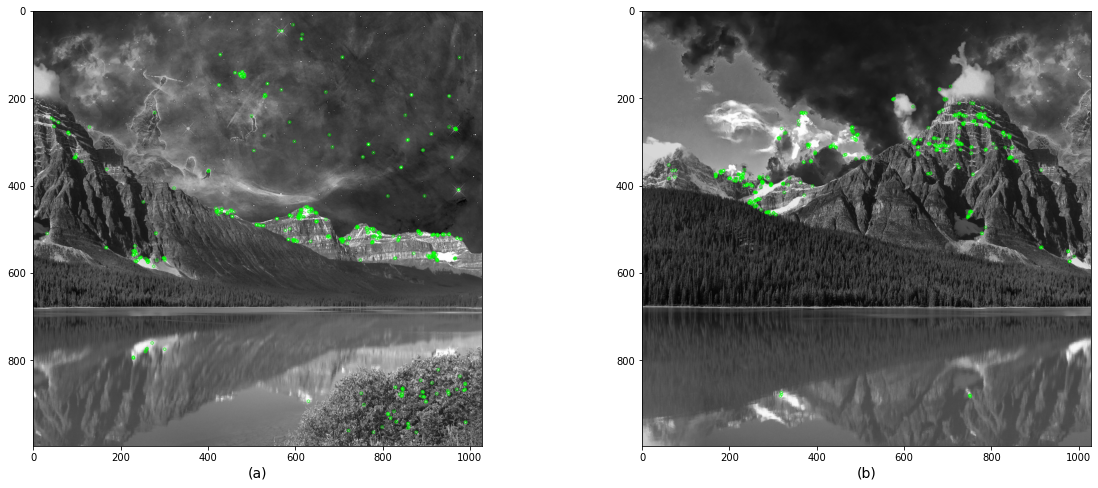

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [ ]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [ ]:
def matchKeyPointsBF(f1, f2, method):
    bf = createMatcher(method, crossCheck=True)
    best_matches = bf.match(f1,f2)
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

Raw matches (Brute force): 146


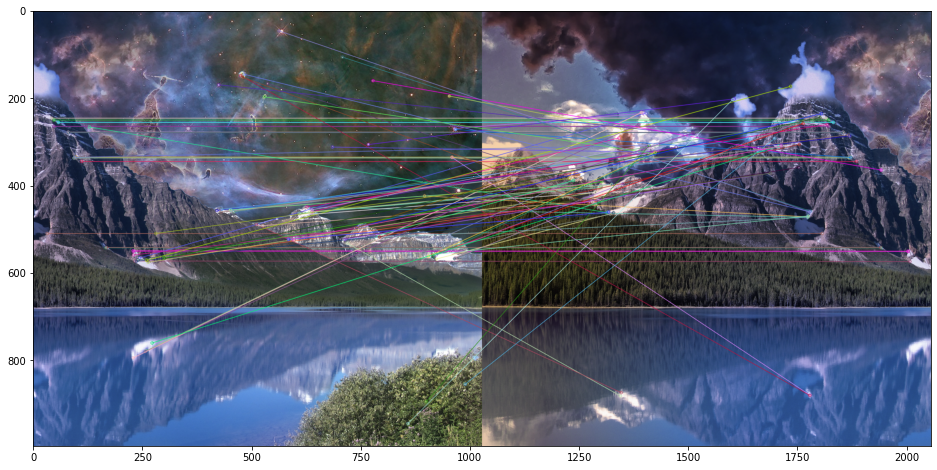

In [ ]:
fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(f1, f2, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kp1,queryImg,kp2,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

In [ ]:
def getHomography(kp1, kp2, f1, f2, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])
    
    if len(matches) > 4:

        pt1 = np.float32([kp1[m.queryIdx] for m in matches])
        pt2 = np.float32([kp2[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(pt1, pt2, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
M = getHomography(kp1, kp2, f1, f2, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.08490707e+00 -7.38064303e-02  7.48506356e+02]
 [ 3.83527978e-02  9.56081418e-01  5.27303626e+00]
 [ 1.13867223e-04 -8.24303897e-05  1.00000000e+00]]


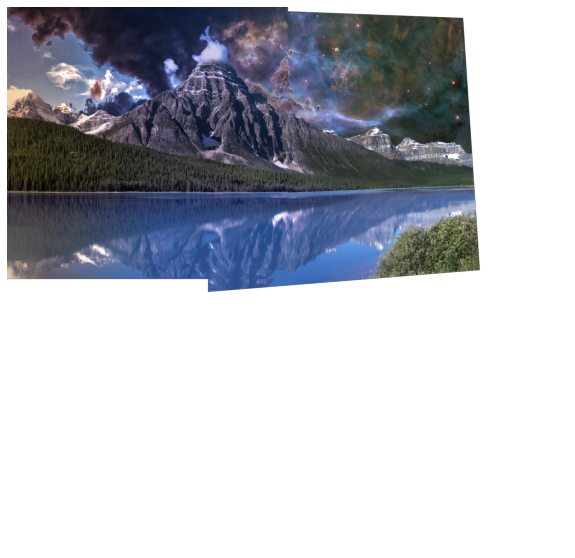

In [ ]:
width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

File saved successfully


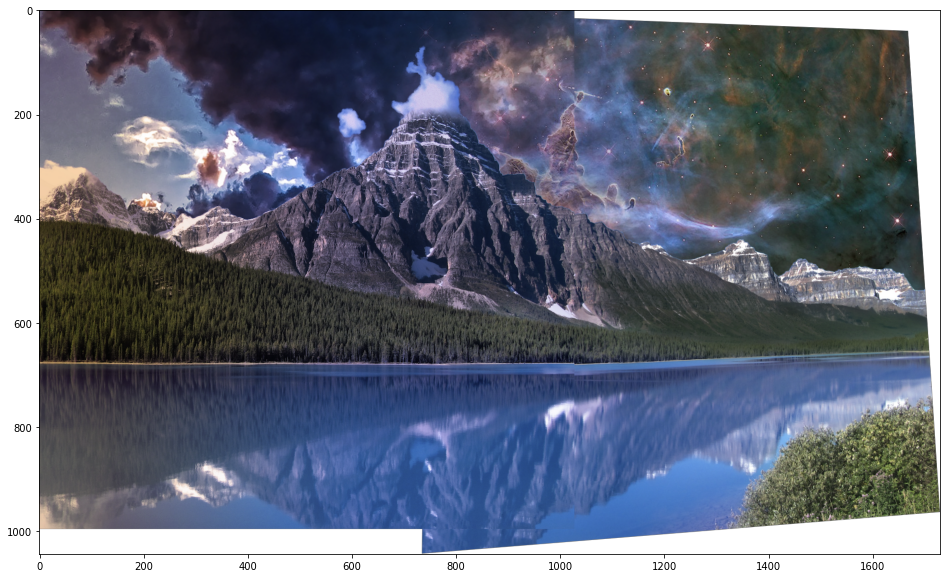

In [ ]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

c = max(cnts, key=cv2.contourArea)

(x, y, w, h) = cv2.boundingRect(c)
result = result[y:y + h, x:x + w]

plt.figure(figsize=(20,10))
plt.imshow(result)

result=cv2.imwrite(r'/media/final.png', result)
if result == True:
  print("File saved successfully")
else:
  print("Error in saving file")

In [ ]:
final=cv2.imread("/media/final.png")

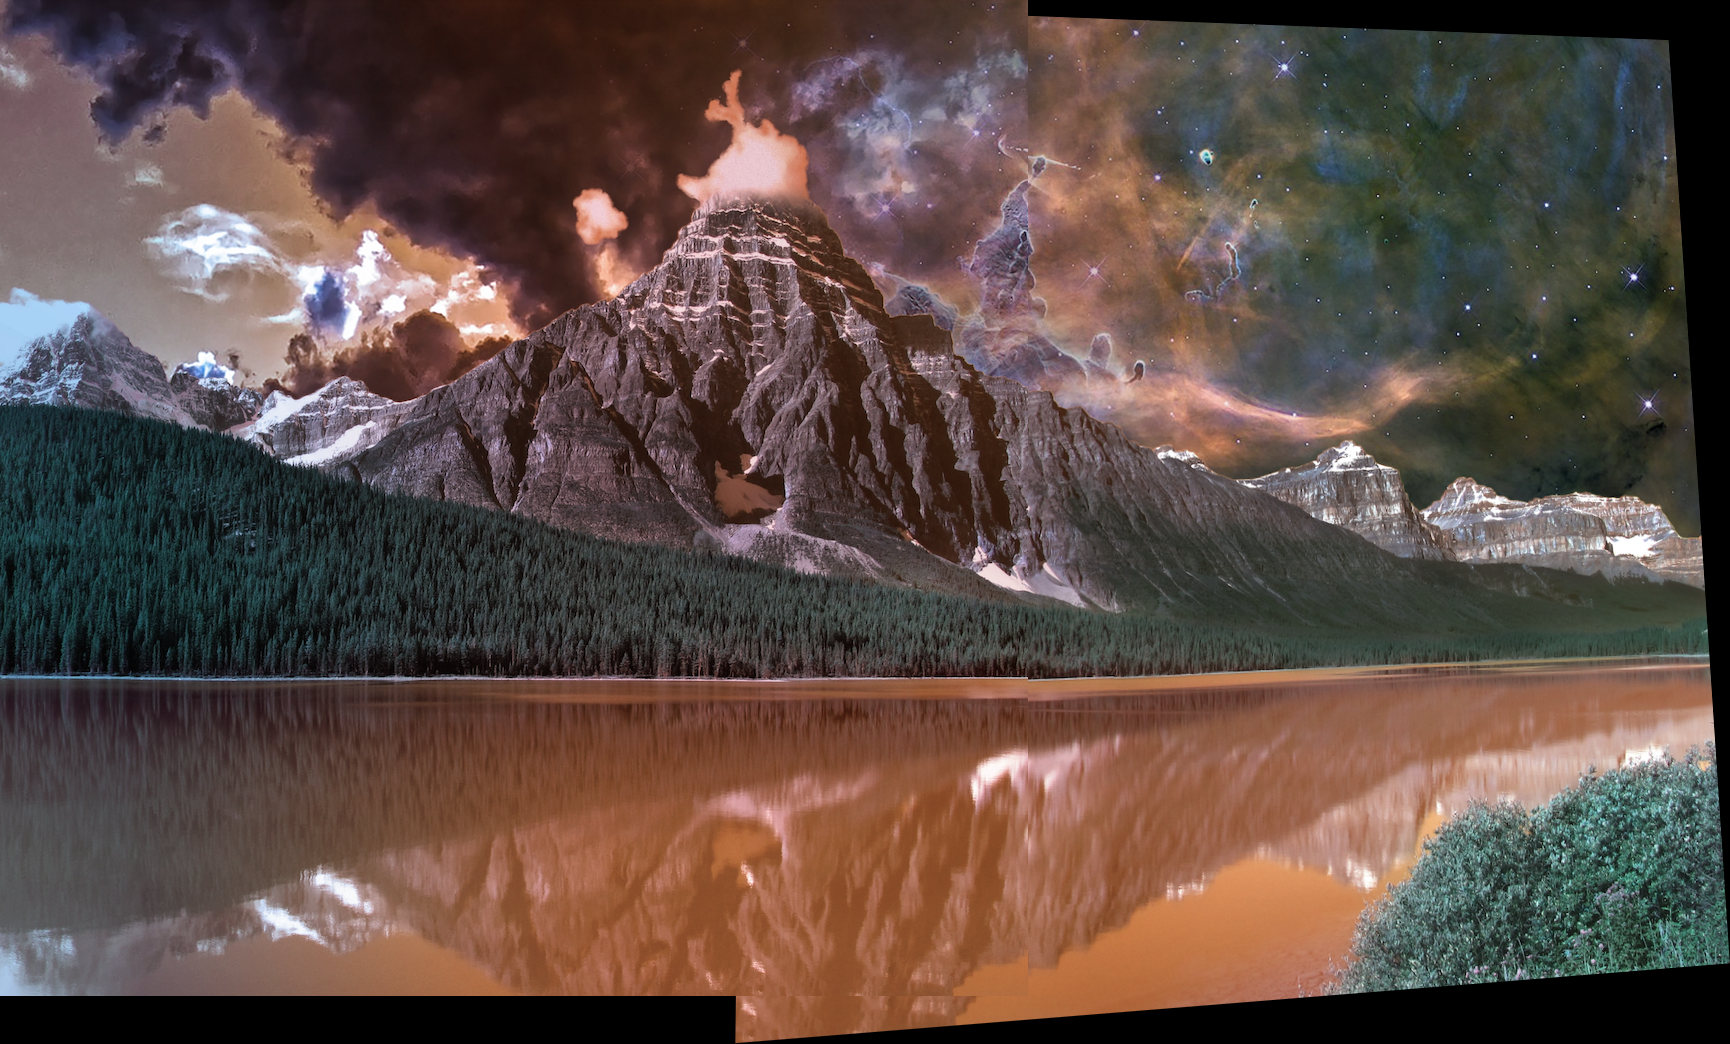

In [ ]:
cv2_imshow(final)